# Project 6 - Title
**Author:** Karli Dean\
**Date:** November 25, 2025\
**Purpose and Introduction:** Everyone needs insurance, but there are many metrics to define how insurance is priced, and it isn't just a flat rate or steady incline. Sometimes it deals with smoking or preexisting health conditions, sometimes it is luck of the draw or insurance provider. In this dataset from [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance), we get to assume there is only 1 insurance provider and analyze what factors are most important in deciding that Policyholder's rate. We will be looking at Linear Regressions and Elastic Net Models to complete this.

In [277]:
# Session Imports
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


## Section 1 - Import and Inspect the Data

### 1.1 - Load the Dataset and Display the Head

In [278]:
# Download the Dataset
source_path = kagglehub.dataset_download("mirichoi0218/insurance")
print("Downloaded to:", source_path)

# Set up my data folder target
target_path = "../data"  # relative to ml-regression-karlidean

os.makedirs(target_path, exist_ok=True)

# Copy the dataset into the folder
for filename in os.listdir(source_path):
    src = os.path.join(source_path, filename)
    dst = os.path.join(target_path, filename)
    if os.path.isfile(src):
        shutil.copy(src, dst)

print("Files copied to:", os.path.abspath(target_path))



Downloaded to: C:\Users\karli\.cache\kagglehub\datasets\mirichoi0218\insurance\versions\1
Files copied to: c:\Repos\ml-regression-karlidean\data


In [279]:
# Defining the dataframe
df = pd.read_csv("../data/insurance.csv")

In [280]:
df.shape

(1338, 7)

In [281]:
# Viewing the head and shape of the function
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 - Check for Missing Values and Explore Summaries

In [282]:
# Checking to see what features have null values in the dataset
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Reflection 1 - 
1. **What do you notice about the data?** I noticed there are no null values in this dataset, but there are inconsistencies in the charges value. I plan on making this rounded, as it is a cost number and we won't be paying fractions of pennies. I also plan on cleaning the data to have the categorical features become numerical or dropped.
2. **Are there any data issues?** No clear issues yet, just those mild inconsistencies mentioned earlier.

## Section 2 - Data Exploration and Preparation

### 2.1 - Explore Data Patterns and Distributions

<Axes: xlabel='bmi', ylabel='charges'>

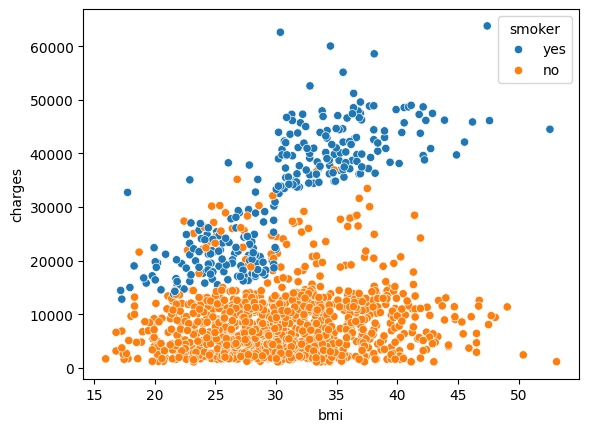

In [283]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')

<Axes: xlabel='smoker', ylabel='count'>

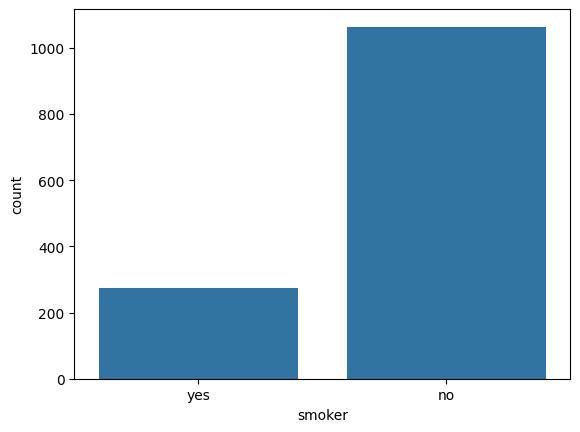

In [284]:
sns.countplot(data=df, x='smoker')

<Axes: xlabel='sex', ylabel='count'>

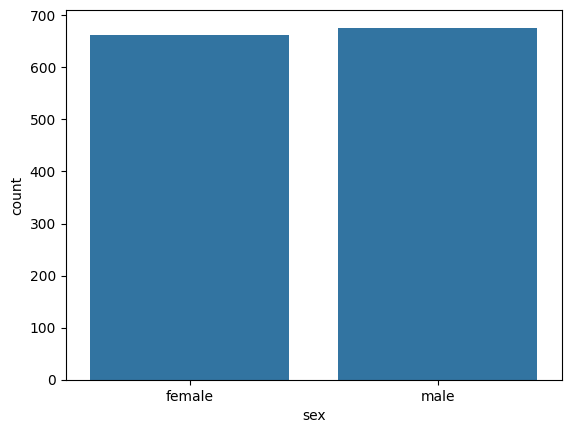

In [285]:
sns.countplot(data=df, x='sex')

### 2.2 - Handle Missing Values, Clean Data, and Data Engineering

In [286]:
# Changing sex and smoker to a binary field
df['sex_binary'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker_binary'] = df['smoker'].map({'yes': 1, 'no': 0})

# Dropping categorical columns
df = df.drop(columns=['sex', 'smoker', 'region'], errors='ignore')

# Rounding the charges feature to only 2 decimals
df['charges'] = df['charges'].round(2)

# Keeping records only within 2 sd's of the person's BMI
mean_bmi = df['bmi'].mean()
std_bmi = df['bmi'].std()

# Keep rows within ±2 SD
df = df[(df['bmi'] >= mean_bmi - 2*std_bmi) & (df['bmi'] <= mean_bmi + 2*std_bmi)]

<Axes: >

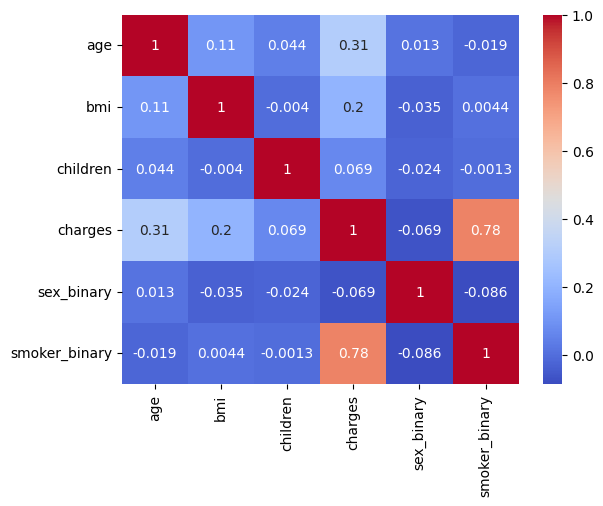

In [287]:
# Look at a correlation heatmap to make educated feature selections!
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

### Reflection 2 - 
1. **What patterns or anomalies do you see?** I see heavy correlation with smoking to higher costs, as well as higher BMI to higher charges.
2. **Do any features stand out?** I think the smoker feature stands out the most, followed by age and BMI. I'm not very surprised at these standouts.
3. **What preprocessing steps were necessary to clean and improve the data?** To improve the data, I made the categorical items numerical (in this case it was binary). I also dropped any categorical features I did not find useful (included the categories that are now binary). I also removed records that were more than 2 standard deviations away in the BMI feature.
4. **Did you create or modify any features to improve performance?** The features I created were just to have binary record and notation, and I removed records (also described in question 3 of this section).

## Section 3 - Feature Selection and Justification

### 3.1 - Choose Features and Target

#### Our Features in the Dataframe
- Age - Policyholder/Primary Beneficiary's age
- BMI - Policyholder/Primary Beneficiary's Body Mass Index - Normal Range is 18.5 - 24.9. Overweight range is 25.0 - 29.9. BMI's greater than 30 are considered obese and BMI's under 18.5 are considered Underweight.
- Children - How many children or dependents a Policyholder has
- Charges - How much a policy's medical costs (billed by health insurance) are worth in USD
- Sex-Binary - A binary indicator of the Policyholder's Sex - 1 = Female, 0 = Male
- Smoker-Binary - A binary indicator of the Policyholder's Smoking Habits - 1 = Smoker, 0 = Non-Smoker

### 3.2 - Define X and y

In [288]:
# Defining y (target)
y = df['charges']

X = df.drop(['charges', 'children', 'sex_binary'], axis=1)
# Features chosen: age, BMI, smoker_binary

### Reflection 3 - 
1. **Why did you choose these features?** I chose these features as they had the highest correlation to the target variable 'charges' in our heatmap
2. **How might they impact predictions or accuracy?** As these had the 3 highest correlations, I feel like these could predict the model effectively.

## Section 4 - Train a Model for Linear Regression

### 4.1 - Split the Data

In [289]:
# Creating Training and Testing Groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### 4.2 - Train the Model

In [290]:
# Training the first linear regression model
lr_model1 = LinearRegression().fit(X_train, y_train)

In [291]:
# Testing the first linear regression model
y_pred_train1 = lr_model1.predict(X_train)
y_pred_test1 = lr_model1.predict(X_test)

### 4.3 - Evaluate Performance Metrics

In [292]:
# Printing the first linear regression model's metrics
print("LR 1: Training R²:", r2_score(y_train, y_pred_train1))
print("LR 1: Test R²:", r2_score(y_test, y_pred_test1))
print("LR 1: Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test1)))
print("LR 1: Test MAE:", mean_absolute_error(y_test, y_pred_test1))

LR 1: Training R²: 0.7337474063311107
LR 1: Test R²: 0.7967585633115105
LR 1: Test RMSE: 5314.4186811419395
LR 1: Test MAE: 3960.0537059567887


### Reflection 4 - 
1. **How well did the model perform?** The model performed with 79% accuracy in the testing data, and a lower margin of error than that of the testing data. That is a very good turnout for a base model.
2. **Are there any surprises in the results?** I was surprised with how well the system worked on the first try, and I was shocked at how big the MAE metric was. However, I remembered this was calculated using the target variable, which is thousands of dollars. It makes more sense in context.

## Section 5 - Improve the Model or Try Alternates (Implement Pipelines)

### 5.2 - Implement Pipeline - Elastic Net Model

In [293]:
# Setiing up Elastic Net Model
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)
y_pred_elastic = elastic_model.predict(X_test)

### 5.3 - Complete Model Comparison

In [294]:
# Comparison Report
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")


report("Linear", y_test, y_pred_test1)
report("ElasticNet", y_test, y_pred_elastic)

Linear R²: 0.797
Linear RMSE: 5314.4186811419395
Linear MAE: 3960.05

ElasticNet R²: 0.628
ElasticNet RMSE: 7190.148375096567
ElasticNet MAE: 5417.18



### Reflection 5 - 
1. **Which models performed better?** The linear regression model performed better than the Elastic Net, but it was still a good way to look at the problem.
2. **How does scaling impact results?** Scaling impacted the results by giving a more "dialed in" difference between records and reality in the original Linear Regression Model. Where scaling can help improve R2's in some scenarios, I feel like this was not the case in this dataset. We don't have enough features to find answers on if more correlating details would be beneficial or not. For example if someone had preexisting health conditions at the time of purchasing the policy or not.

## Section 6 - Final Thoughts and Insights

### 6.1 - Summary

The Linear Regression model performed significantly better than the Elastic Net across all metrics. It was able to explain nearly 80% of the variance in medical charges, where the Elastic net was only able to explain about 63% of charges. The Elastic Net seemed almost too restricted to capture the relationships between the features. With this, the Elastic Net model performed surprisingly well for the data.

### 6.2 - Challenges Faced

Truthfully, I didn't encounter many issues with my data. When I was stuck in codes, I would reference my past coursework to look at a roadmap for a way out.

### 6.3 - If I had more time...

If I had more time, I would analyze all of the model types we did in P4, even though I know the polynomial wouldn't perform the best. I tried it before I switched to the elastic net.

### Reflection 6 -
1. **What did you learn from this project?** I learned that not every model is for every problem. Though it was something I knew in concept, I hadn't seen it in practice as much. It was nice to be able to see this upon the same correlation. I will keep it in mind when completing EDA's in the future.